# Probing Syntax in LLMs
by Lars Kulbe, Maxim Kurvink & Ole Jürgensen

#### Import libraries

In [27]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage


## Introduction to Parsing Trees

In [30]:
url = 'https://upload.wikimedia.org/wikipedia/commons/5/5c/Parse2.jpg'
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
img = PILImage.open(BytesIO(response.content))
plt.imshow(img)
plt.axis('off')
plt.show()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7cf31c44d800>

In [20]:
sentences_train = []
sentences_test = []

# Use the raw file URL
root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
files = {
    "test": "en_ewt-ud-test.conllu", 
    "train": "en_ewt-ud-train.conllu"
    }

for key, file in files.items():
    file_url = os.path.join(root_url, file)
    response = requests.get(file_url)
    response.raise_for_status()  # Ensure the request was successful


    file_content = StringIO(response.text)
    for sentence in parse_incr(file_content):
        if key == "test":
            sentences_test.append(sentence)
        if key == "train":
            sentences_train.append(sentence)

[[0 1 3 2 4 4 3 4 4 3 2]
 [1 0 2 1 3 3 2 3 3 2 1]
 [3 2 0 1 3 3 2 3 3 2 3]
 [2 1 1 0 2 2 1 2 2 1 2]
 [4 3 3 2 0 2 1 4 4 3 4]
 [4 3 3 2 2 0 1 4 4 3 4]
 [3 2 2 1 1 1 0 3 3 2 3]
 [4 3 3 2 4 4 3 0 2 1 4]
 [4 3 3 2 4 4 3 2 0 1 4]
 [3 2 2 1 3 3 2 1 1 0 3]
 [2 1 3 2 4 4 3 4 4 3 0]]
[1 0 2 1 3 3 2 3 3 2 1]


<Axes: >

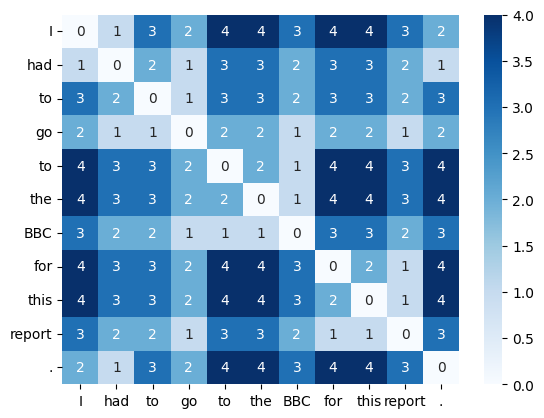

In [24]:
def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor when walking from node b up (closest to b)
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms

# Example usage:
s = sentences_test[60]
mat, ids, root_dist, forms = distance_matrix_from_sentence(s)
print(mat)
print(root_dist)
sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True)

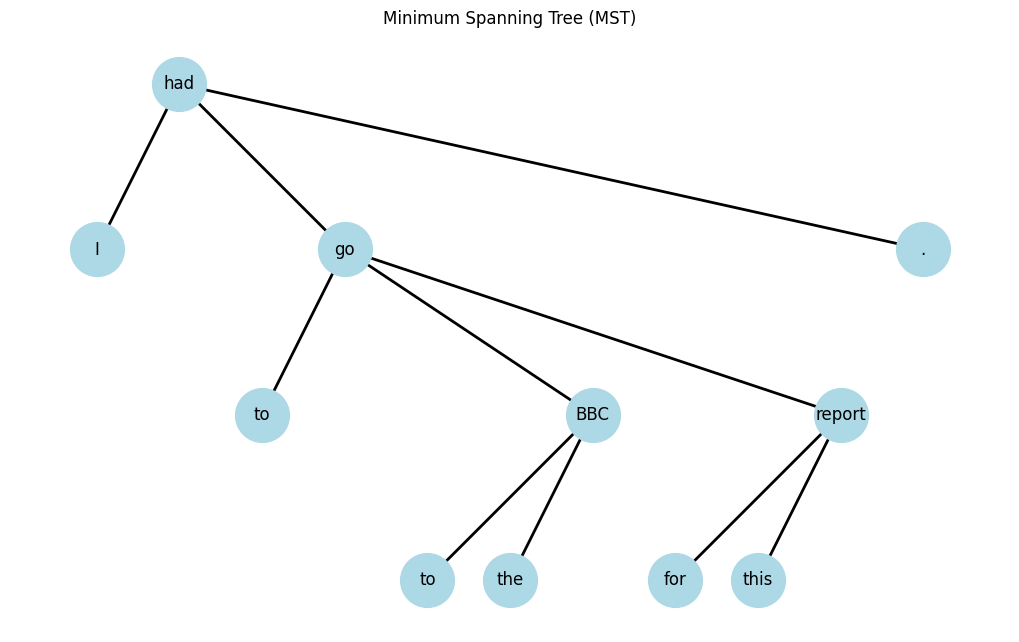

In [ ]:
# Create an undirected weighted graph from the matrix
G = nx.from_numpy_array(mat)     # weights stored in 'weight'

# Compute MST using Kruskal’s algorithm
mst = nx.minimum_spanning_tree(G, algorithm="kruskal")

# Prepare node positions: x=ids, y=root_dist
pos = {i: (id, len(root_dist) -root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

plt.figure(figsize=(10, 6))
nx.draw(
    mst,
    pos=pos,
    with_labels=True,
    labels={i: forms[i] for i in range(len(forms))}, 
    node_color='lightblue',
    edge_color='black',
    node_size=1500,
    width = 2,
)
plt.xlabel("ids")
plt.ylabel("root_dist")
plt.title("Minimum Spanning Tree (MST)")
plt.show()